In [2]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn & XGBoost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from xgboost import XGBClassifier

# Configuration
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [3]:
# --- 2. Data Loading & Cleaning ---
def load_and_clean_data(filepath):
    """
    Loads CSV, converts 'TotalCharges' to numeric, fills missing values,
    and maps the target variable 'Churn' to 0/1.
    """
    df = pd.read_csv(filepath)
    
    # Force 'TotalCharges' to numeric (errors become NaN)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Fill missing TotalCharges with 0 (assuming new customers)
    df['TotalCharges'].fillna(0, inplace=True)
    
    # Map Target: 'Yes'->1, 'No'->0
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    
    print(f"Data Loaded. Shape: {df.shape}")
    return df

# Usage
# UPDATE THIS PATH if your csv is in a different folder
df = load_and_clean_data('../data/Telco-Customer-Churn.csv') 
df.head()

Data Loaded. Shape: (7032, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [4]:
# --- 3. Feature Engineering ---
def create_domain_features(df):
    """
    Creates tenure cohorts and ratio features.
    """
    df_eng = df.copy()
    
    # 1. Tenure Cohorts (Binning)
    # 0-12 months, 13-24 months, etc.
    bins = [0, 12, 24, 48, 60, np.inf]
    labels = ['0-12m', '13-24m', '25-48m', '49-60m', '60m+']
    df_eng['tenure_group'] = pd.cut(df_eng['tenure'], bins=bins, labels=labels)
    
    # 2. Charges Ratio (Monthly vs Total)
    # Avoid division by zero
    df_eng['charges_per_tenure'] = df_eng['TotalCharges'] / (df_eng['tenure'] + 1)
    
    print("Domain features created.")
    return df_eng

df_processed = create_domain_features(df)
df_processed[['tenure', 'tenure_group', 'charges_per_tenure']].head()

Domain features created.


,tenure,tenure_group,charges_per_tenure
0,1,0-12m,14.925000
1,34,25-48m,53.985714
2,2,0-12m,36.050000
3,45,25-48m,40.016304
4,2,0-12m,50.550000


In [5]:
# --- 4. Data Splitting ---
# Separate Features (X) and Target (y)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# Stratified Split to maintain Churn ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape:  {X_test.shape}")

Training shape: (5625, 22)
Testing shape:  (1407, 22)


In [6]:
# --- 5. Pipeline Setup (Preprocessing + Model) ---

# Define Categorical and Numerical columns
categorical_cols = [c for c in X.columns if X[c].dtype == 'object' or c == 'tenure_group']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'charges_per_tenure']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Pipeline: Preprocessor -> XGBoost
# Note: scale_pos_weight helps with class imbalance
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        scale_pos_weight=3  # Increases weight of Churn class (approx ratio 73:27)
    ))
])

print("Pipeline constructed.")

Pipeline constructed.


In [7]:
# --- 6. Model Training ---
print("Training model...")
model_pipeline.fit(X_train, y_train)
print("Training complete.")

Training model...
Training complete.


--- Classification Report (Threshold: 0.3) ---
              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1033
           1       0.43      0.89      0.58       374

    accuracy                           0.66      1407
   macro avg       0.68      0.73      0.64      1407
weighted avg       0.80      0.66      0.67      1407

ROC-AUC Score: 0.8353


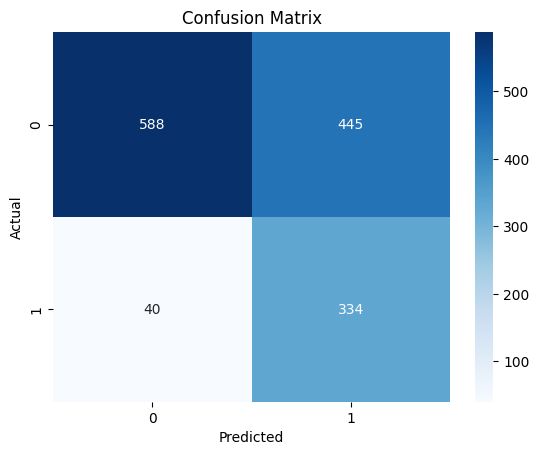

In [8]:
# --- 7. Evaluation with Threshold Tuning ---
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

# Set custom threshold to prioritize Recall
THRESHOLD = 0.3
y_pred_custom = (y_prob >= THRESHOLD).astype(int)

print(f"--- Classification Report (Threshold: {THRESHOLD}) ---")
print(classification_report(y_test, y_pred_custom))

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

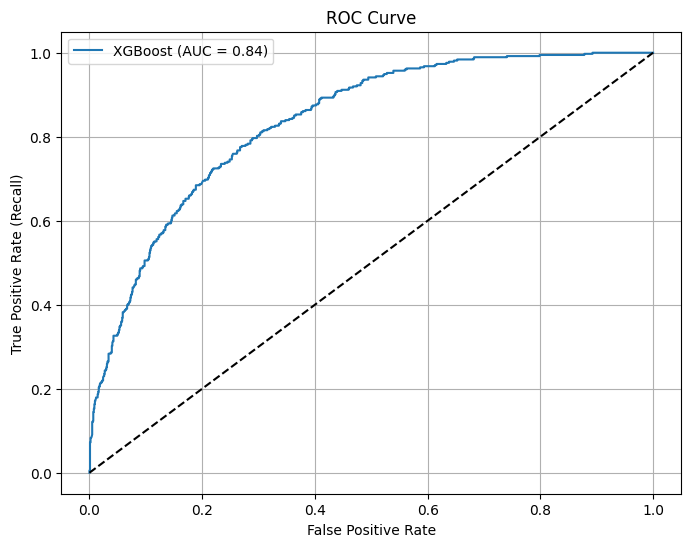

In [9]:
# --- 8. ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# --- 9. Generate Full Risk Report ---

# 1. Predict probabilities for the WHOLE dataset (or just test set)
# Here we use the whole processed dataset to score everyone
all_probs = model_pipeline.predict_proba(X)[:, 1]

# 2. Create results DataFrame
risk_df = df.copy()
risk_df['Churn_Probability'] = all_probs

# 3. Assign Risk Levels
def get_risk_level(prob):
    if prob > 0.70: return 'High Risk'
    elif prob > 0.30: return 'Medium Risk'
    else: return 'Low Risk'

risk_df['Risk_Level'] = risk_df['Churn_Probability'].apply(get_risk_level)

# 4. Sort by highest probability first
risk_report = risk_df.sort_values(by='Churn_Probability', ascending=False)

# 5. Select key columns for the final report
output_cols = ['customerID', 'Churn_Probability', 'Risk_Level', 'Contract', 'MonthlyCharges', 'tenure']
final_report = risk_report[output_cols]

# 6. Save to CSV
final_report.to_csv('all_customers_risk_report.csv', index=False)

print("Report generated: 'all_customers_risk_report.csv'")
display(final_report.head(10))

Report generated: 'all_customers_risk_report.csv'


,customerID,Churn_Probability,Risk_Level,Contract,MonthlyCharges,tenure
2203,7216-EWTRS,0.973395,High Risk,Month-to-month,100.80,1
6473,5419-JPRRN,0.973395,High Risk,Month-to-month,101.45,1
6855,0295-PPHDO,0.971062,High Risk,Month-to-month,95.45,1
3374,5178-LMXOP,0.969309,High Risk,Month-to-month,95.10,1
2572,4910-GMJOT,0.969309,High Risk,Month-to-month,94.60,1
4792,9300-AGZNL,0.969309,High Risk,Month-to-month,94.00,1
2792,6023-YEBUP,0.967313,High Risk,Month-to-month,100.95,3
3864,5299-SJCZT,0.966614,High Risk,Month-to-month,101.55,3
1971,9497-QCMMS,0.966283,High Risk,Month-to-month,93.55,1
3204,8149-RSOUN,0.966119,High Risk,Month-to-month,93.85,1
